# Tutorial on Bayesian linear regression

**Alfredo Garbuno-Inigo**  
Phd student, University of Liverpool  
Institute for Risk and Uncertainty

In [2]:
%matplotlib inline
from pymc3 import *
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Case study: Admittance to university. 


In [120]:
d = {'dept': ['A','A','B','B','C','C','D','D','E','E','F','F'], 
    'gender': ['male','female','male','female','male','female','male','female','male','female','male','female'], 
    'admit': [512,89,353,17,120,202,138,131,53,94,22,24], 
    'reject': [313,19, 207, 8,205,391 ,279, 244, 138 ,299, 351, 317], 
     'applications': [825,108,560,25,325,593,417,375,191,393,373,341]
    }
df = pd.DataFrame(d)

In [121]:
print 'Number of records: %s' %(df.shape[0])
print 'Number of features: %s' %(df.shape[1])

Number of records: 12
Number of features: 5


In [122]:
df.head(3)

,admit,applications,dept,gender,reject
0,512,825,A,male,313
1,89,108,A,female,19
2,353,560,B,male,207


In [123]:
dfsum = df.sum()[['admit','reject','applications']]
dfsum

admit           1755
reject          2771
applications    4526
dtype: object

# Case study: Admittance to university. 

In [124]:
print 'Acceptance rate: %s' %(np.ceil(100*(dfsum['admit']+0.0)/dfsum['applications']))

Acceptance rate: 39.0


In [125]:
df.groupby('gender').sum().apply(lambda x: (100*x['admit']+0.)/x['applications'], axis=1)

gender
female    30.354223
male      44.518766
dtype: float64

In [126]:
df.groupby('dept').sum()[['admit','reject', 'applications']]

,admit,reject,applications
dept,,,
A,601,332,933
B,370,215,585
C,322,596,918
D,269,523,792
E,147,437,584
F,46,668,714


In [127]:
pd.pivot_table(df, values = 'applications', index = 'dept', columns = 'gender', aggfunc=np.sum)

gender,female,male
dept,,
A,108,825
B,25,560
C,593,325
D,375,417
E,393,191
F,341,373


In [128]:
df.groupby('dept').sum().apply(lambda x: 100.0*x[['admit','reject']]/x['applications'],axis=1)

,admit,reject
dept,,
A,64.415863,35.584137
B,63.247863,36.752137
C,35.076253,64.923747
D,33.964646,66.035354
E,25.171233,74.828767
F,6.442577,93.557423


In [129]:
depts = df.dept.unique()
n_depts = len(depts)
dept_table = dict(zip(depts, range(n_depts)))
dept = df.dept.replace(dept_table).values

dept_table

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [130]:
gender = df.gender.replace(dict(zip(df.gender.unique(), range(2))))

dict(zip(df.gender.unique(), range(2)))

{'female': 1, 'male': 0}

## Pooled model

$$ \begin{align}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha & \sim \mathcal{N}(0,1)
\end{align}
$$ 

In [131]:
with Model() as pooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0, shape=2)
    # Linear model
    theta = beta[0] + beta[1]*gender

    # This just computes the link function, no posterior sampling
    # p = pm.invlogit(theta)
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [132]:
n_samples = 3000
n_opt = 20000
n_warm = 1000

with pooled_model:
    pooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 449.66:  47%|████▋     | 9468/20000 [00:01<00:01, 6959.40it/s]
Convergence archived at 10000
Interrupted at 10,000 [50%]: Average Loss = 553.29
100%|██████████| 4000/4000 [00:07<00:00, 527.62it/s]


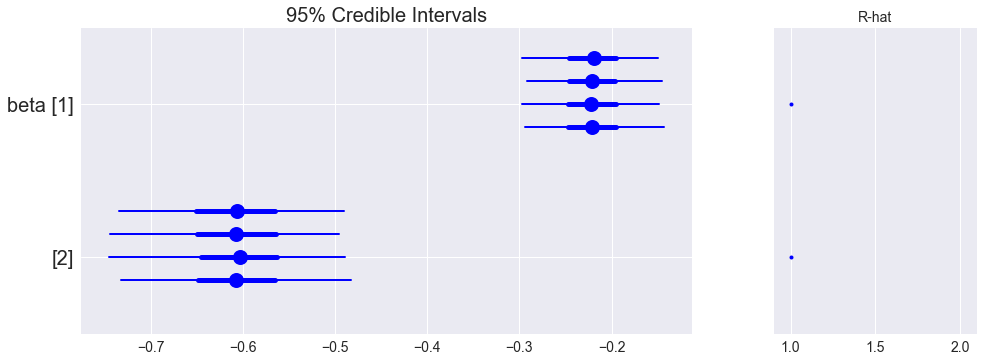

In [133]:
plt.figure(figsize=(15, 5))
forestplot(pooled_trace[n_warm:], varnames = ['beta'], fontsize = 20, linewidth = 5, marker = 'o', markersize = 15, chain_spacing = .15);

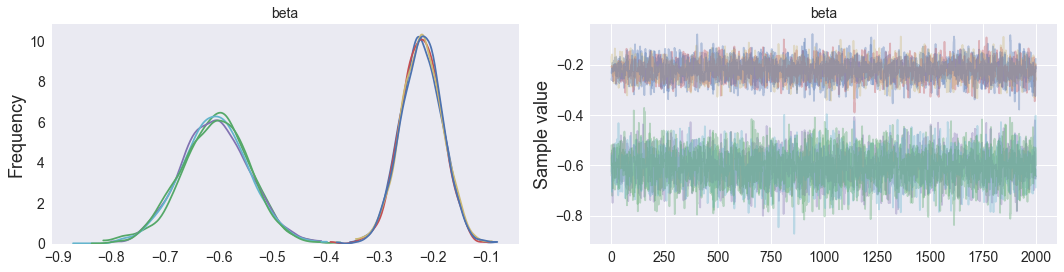

In [134]:
pm.traceplot(pooled_trace[1000:], varnames = ['beta'], figsize=(15, 4));

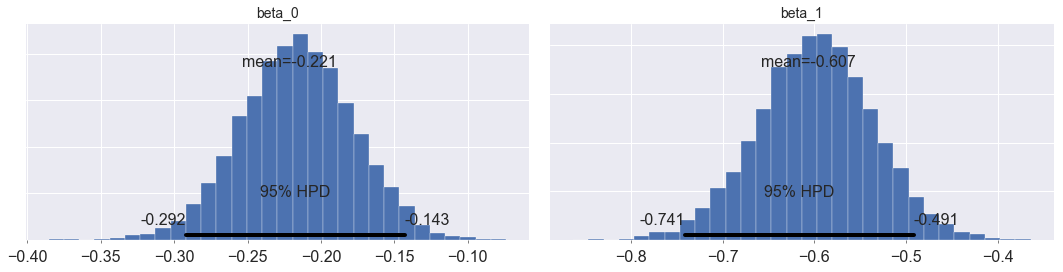

In [135]:
pm.plot_posterior(pooled_trace[1000:], varnames = ['beta'], figsize=(15, 4));

In [136]:
dfsort = df.sort_values(['dept','gender'],ascending=[True, False])
pobs = 1.*dfsort['admit']/dfsort['applications']

phat = pd.Series(pooled_trace[n_warm:]['p'].mean(axis = 0))
pstd = np.sqrt(phat*(1 - phat)/dfsort.applications)

In [137]:
x_loc = [1.5, 3.5, 5.5, 7.5, 9.5]

In [156]:
def plot_admit(phat, pstd):
    plt.figure(figsize=(15, 5)); 
    plt.title('Comparison of observed vs predicted frequencies \n', fontsize = 18)
    plt.scatter(range(len(phat)), phat); 
    plt.scatter(range(len(phat)), pobs, c='k')
    for i, m, se in zip(range(len(phat)), phat, pstd):
        plt.plot([i,i], [m-2*se, m+2*se], 'b:')
    for i in range(0,len(phat)-1,2):
        plt.plot([i,i+1], [phat[i], phat[i+1]], 'b', alpha = .5)
    for i in range(0,len(phat)-1,2):
        plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
    for xc in x_loc: plt.axvline(x=xc, color = 'gray')
    plt.xticks(np.arange(0,12,2)+.5, df.dept.unique(), fontsize = 18); plt.yticks(fontsize = 18);

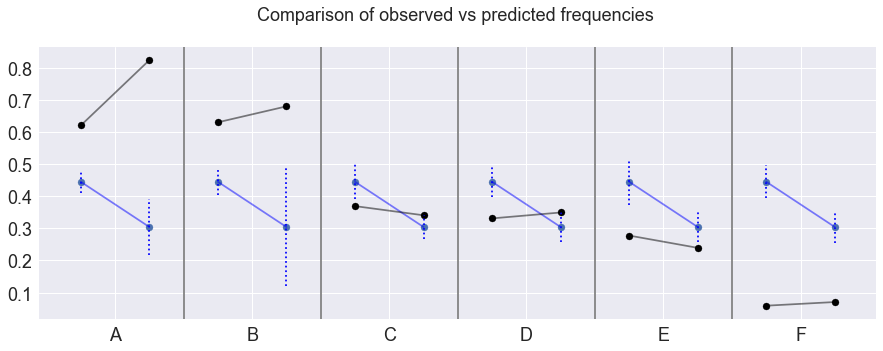

In [157]:
plot_admit(phat, pstd)

## Unpooled model

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(0,1) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\
\end{array}
\end{align}
$$ 

In [144]:
with Model() as unpooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0)
    alpha = Normal('alpha', 0, sd = 1e0, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta * gender
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [145]:
with unpooled_model:
    unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 69.903:  62%|██████▏   | 12406/20000 [00:01<00:01, 6658.59it/s]
Convergence archived at 12700
Interrupted at 12,700 [63%]: Average Loss = 227.14
100%|██████████| 4000/4000 [00:11<00:00, 336.76it/s]


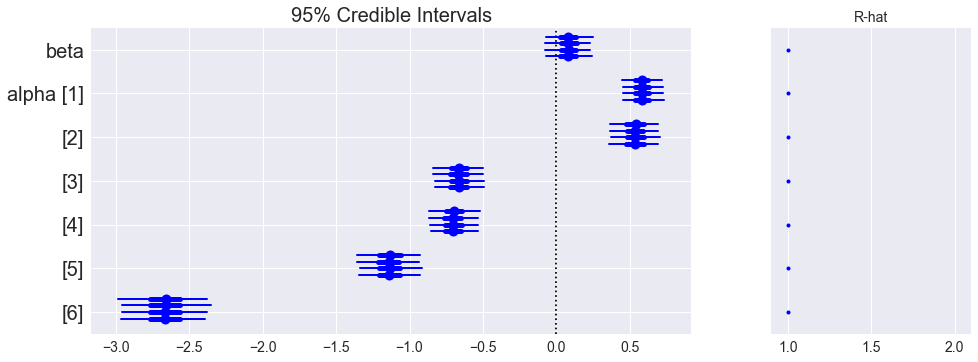

In [146]:
plt.figure(figsize=(15, 5))
forestplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'], fontsize = 20, linewidth = 5, marker = 'o', markersize = 10, chain_spacing = .15);

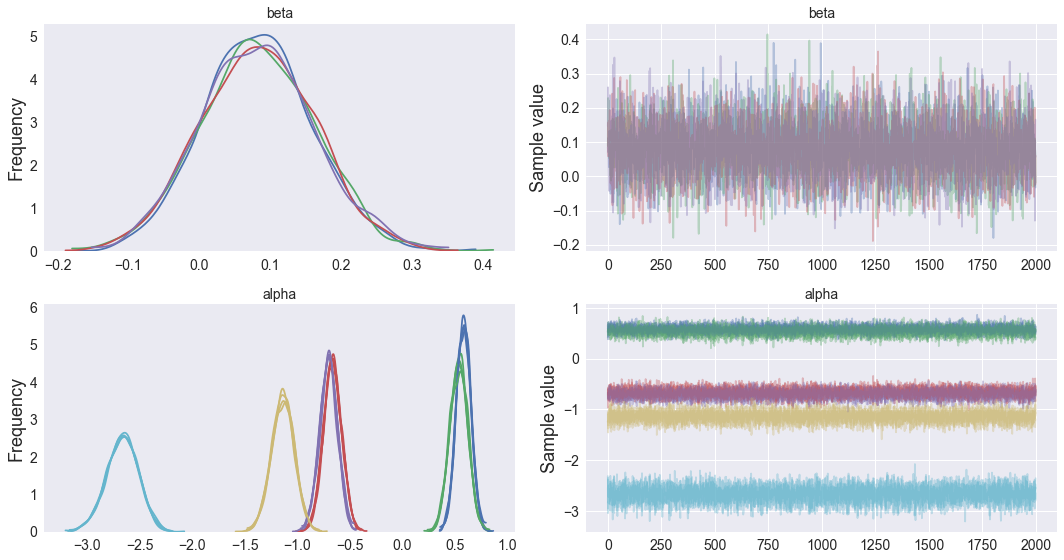

In [147]:
pm.traceplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'], figsize = (15, 8));

In [148]:
phat_unpooled = pd.Series(unpooled_trace[n_warm:]['p'].mean(axis = 0))
pstd_unpooled = np.sqrt(phat_unpooled*(1 - phat_unpooled)/dfsort.applications)

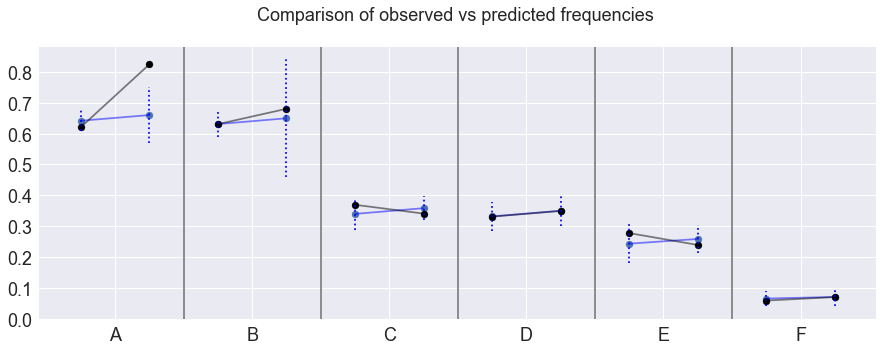

In [158]:
plot_admit(phat_unpooled, pstd_unpooled)

## Hierarchical: *varying intercept*

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(\mu_a,\sigma_a) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\mu_a & \sim \mathcal{N}(0,10) \\
\sigma_a & \sim \text{HalfCauchy}(0,2)
\end{array}
\end{align}
$$ 

In [150]:
with Model() as hierarchical:
    # Priors in highest hierarchy
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = Exponential('sigma_a', 1)
    
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[dept] + beta * gender
    p = pm.Deterministic('p', pm.invlogit(theta))
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [151]:
with hierarchical:
    hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 73.535:  61%|██████    | 12149/20000 [00:02<00:01, 5282.42it/s]
Convergence archived at 12200
Interrupted at 12,200 [61%]: Average Loss = 239.49
100%|██████████| 4000/4000 [00:13<00:00, 300.21it/s]


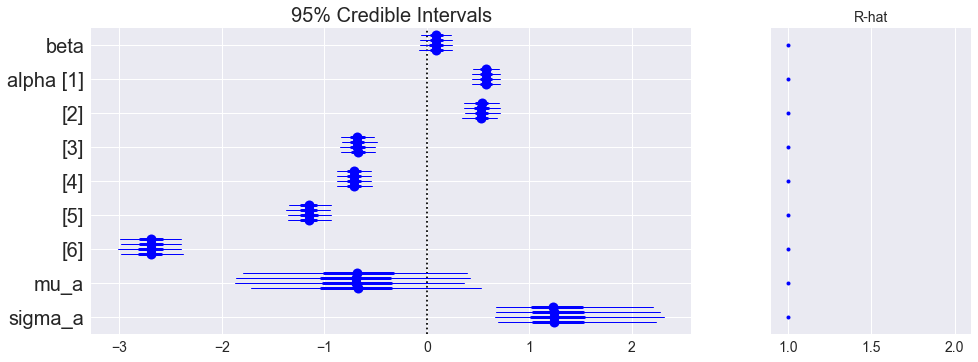

In [152]:
_ = plt.figure(figsize=(15, 5))
forestplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha', 'mu_a', 'sigma_a'], fontsize = 20, linewidth = 3, marker = 'o', markersize = 10, chain_spacing = .15);

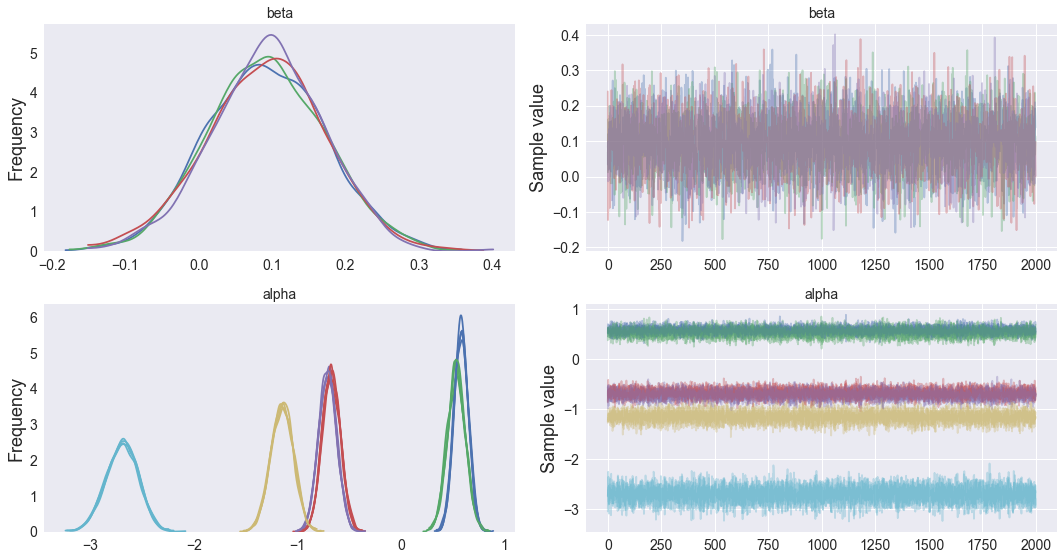

In [153]:
pm.traceplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha'], figsize =(15,8));

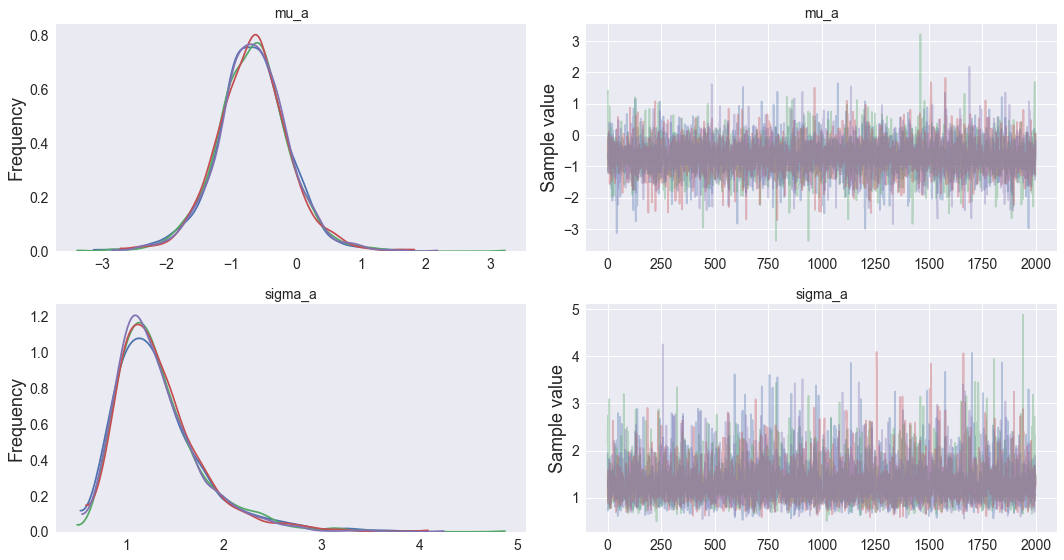

In [154]:
pm.traceplot(hierarchical_trace[1000:], varnames = ['mu_a', 'sigma_a'], figsize = (15,8));

In [155]:
phat_hierarchical = pd.Series(hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_hierarchical = np.sqrt(phat_hierarchical*(1 - phat_hierarchical)/dfsort.applications)

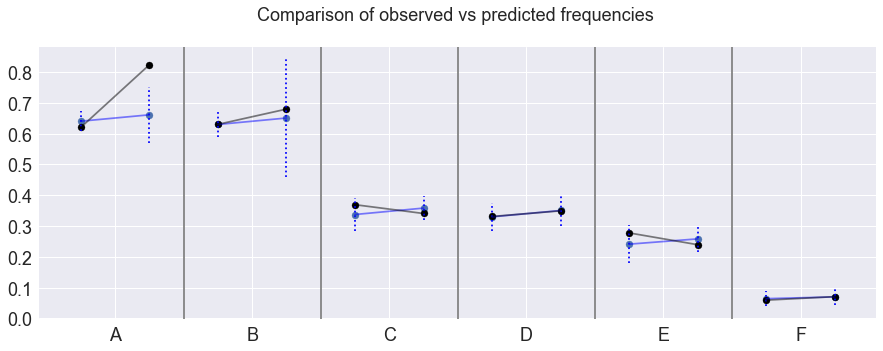

In [159]:
plot_admit(phat_hierarchical, pstd_hierarchical)

## Full hierarchical: *Varying slope and intercept*

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta_{\text{DEPT}[i]} \, m_i \\
\beta_{\text{DEPT}} & \sim \mathcal{N}(\mu_b,\sigma_b) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\alpha_{\text{DEPT}} & \sim \mathcal{N}(\mu_a,\sigma_a) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\mu_a & \sim \mathcal{N}(0,10) \\
\mu_b & \sim \mathcal{N}(0,10) \\
\sigma_a & \sim \text{HalfCauchy}(0,2)\\
\sigma_b & \sim \text{HalfCauchy}(0,2)
\end{array}
\end{align}
$$ 

In [160]:
with Model() as full_hierarchical:
    # Priors in highest hierarchy
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = Exponential('sigma_a', 1)
    mu_b = Normal('mu_b', mu=0., sd=1e1)
    sigma_b = Exponential('sigma_b', 1)
    
    # Priors in regression coefficients
    beta = Normal('beta', mu_b, sd=sigma_b, shape = n_depts)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[dept] + beta[dept] * gender
    p = pm.Deterministic('p', pm.invlogit(theta))  
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [161]:
n_samples = 5000
n_warm = 2000

with full_hierarchical:
    full_hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 73.07:  71%|███████   | 14110/20000 [00:03<00:01, 4008.94it/s] 
Convergence archived at 14300
Interrupted at 14,300 [71%]: Average Loss = 207.41
100%|█████████▉| 6997/7000 [00:42<00:00, 173.79it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 0 contains 26 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 7000/7000 [00:42<00:00, 166.42it/s]
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 47 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning:

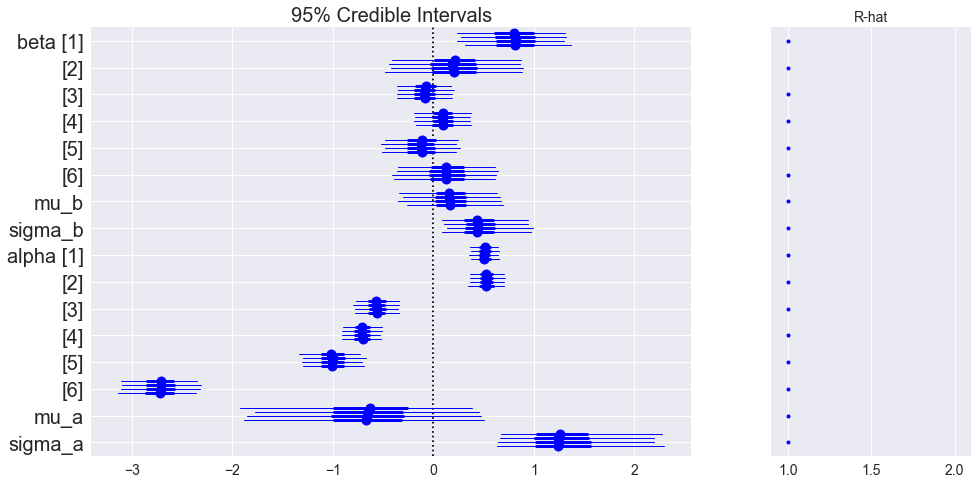

In [162]:
_ = plt.figure(figsize=(15, 7)); 
forestplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'mu_b','sigma_b','alpha', 'mu_a', 'sigma_a'], fontsize = 20, linewidth = 3, marker = 'o', markersize = 10, chain_spacing = .15);

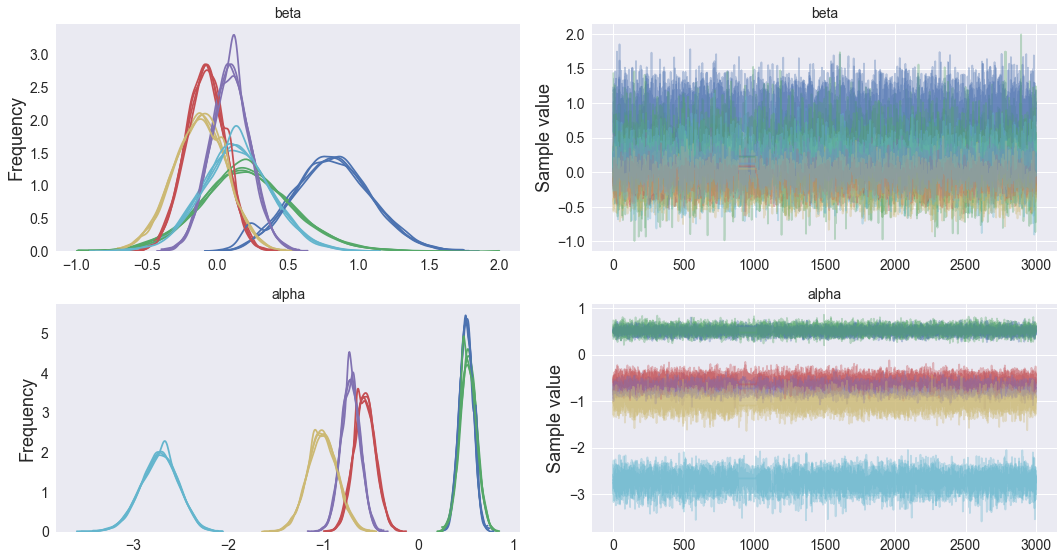

In [163]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha'], figsize=(15, 8)); 

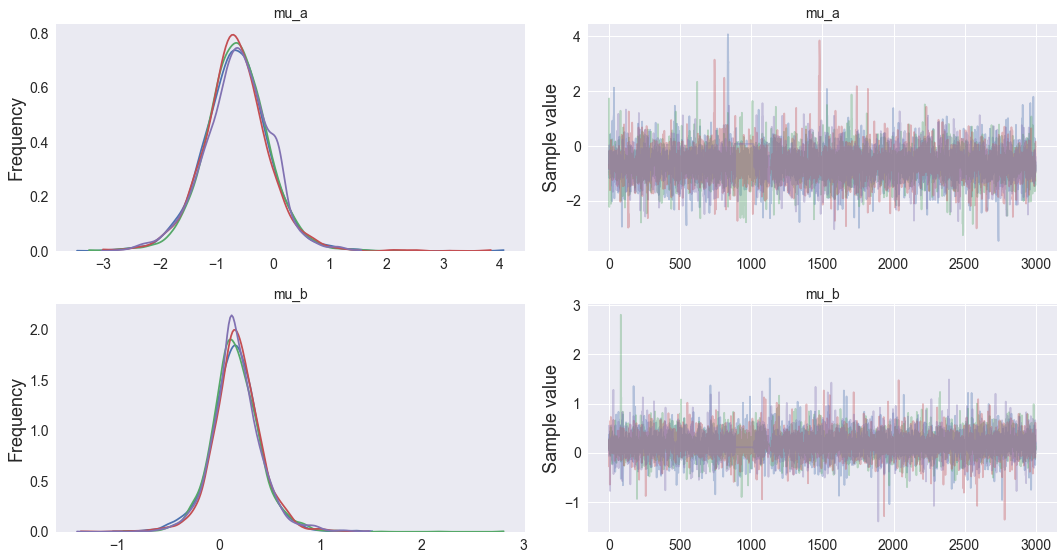

In [164]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['mu_a', 'mu_b'], figsize=(15, 8)); 

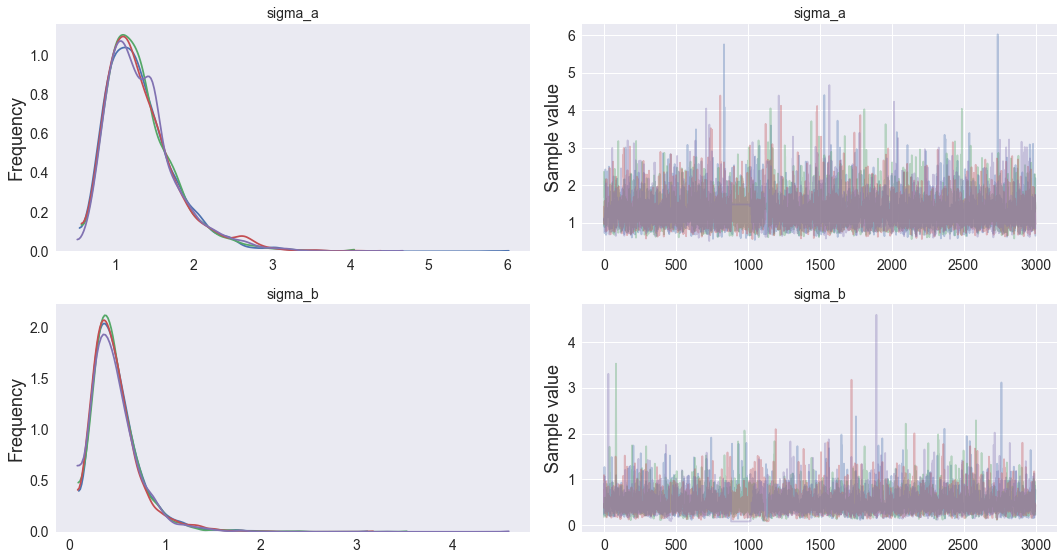

In [165]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['sigma_a', 'sigma_b'], figsize=(15, 8));

In [166]:
phat_fhierarchical = pd.Series(full_hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_fhierarchical = np.sqrt(phat_fhierarchical*(1 - phat_fhierarchical)/dfsort.applications)

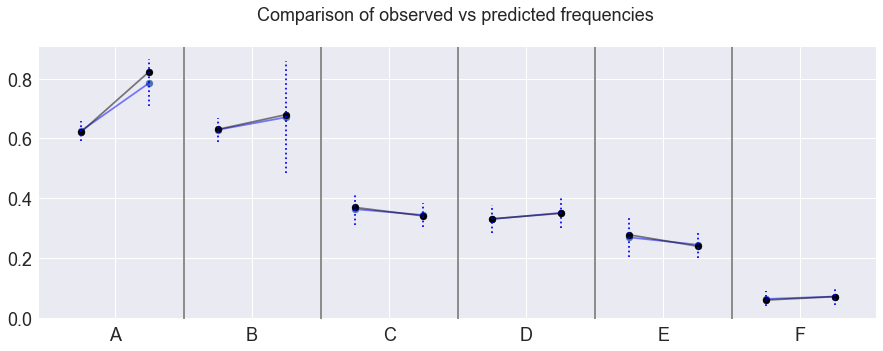

In [167]:
plot_admit(phat_fhierarchical, pstd_fhierarchical)

## Model comparison and model averaging

Instead of comparing likelihoods (never!)

* Deviance Information criteria (DIC)  

* Watanabe-Akaike Information criteria (WAIC)  

### DIC

In [168]:
traces = [pooled_trace, unpooled_trace, hierarchical_trace, full_hierarchical_trace]
models = [pooled_model, unpooled_model, hierarchical, full_hierarchical]
models_list = ['Pooled '+'.'*23, 'Unpooled '+'.'*21, 'Varying intercept '+'.'*12, 'Varying intercept and slope ..']

for t, m, n in zip(traces, models, models_list):
    print '%s \t : %s' %(n, pm.stats.dic(t,m))

Pooled ....................... 	 : 860.531392727
Unpooled ..................... 	 : 126.049637247
Varying intercept ............ 	 : 135.760578636
Varying intercept and slope .. 	 : 140.81519463


### WAIC

In [169]:
pm.stats.waic(full_hierarchical_trace, full_hierarchical)

WAIC_r(WAIC=90.841302881572219, WAIC_se=4.6213033855159313, p_WAIC=6.7716079091408998)

In [170]:
pm.stats.compare(traces, models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
3,90.8413,6.77161,0,0.999664,4.6213,0,0
1,108.123,9.13829,17.282,0.000176646,16.2024,13.05,0
2,108.324,9.24666,17.4822,0.000159821,15.7188,12.525,0
0,985.063,112.309,894.222,6.63708e-195,310.215,310.474,0


## Shrinkage

In [171]:
with Model() as unpooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0, shape = n_depts)
    alpha = Normal('alpha', 0, sd = 1e0, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta[dept] * gender
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [172]:
with unpooled_model:
    unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 66.895:  68%|██████▊   | 13673/20000 [00:02<00:00, 6615.34it/s]
Convergence archived at 14100
Interrupted at 14,100 [70%]: Average Loss = 199.51
100%|██████████| 7000/7000 [00:31<00:00, 220.05it/s]


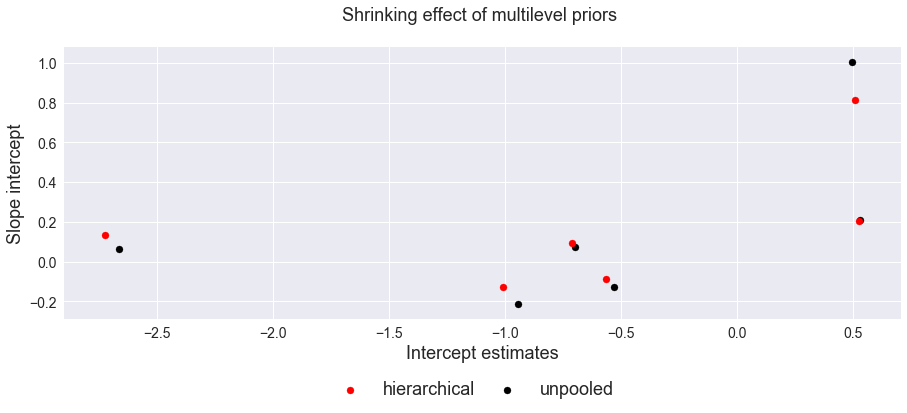

In [177]:
plt.figure(figsize=(15, 5));
plt.title('Shrinking effect of multilevel priors \n' , fontsize = 18)
plt.scatter(unpooled_trace[n_warm:]['alpha'].mean(axis=0), 
            unpooled_trace[n_warm:]['beta'].mean(axis=0), c ='k', label = 'unpooled');
plt.scatter(full_hierarchical_trace[n_warm:]['alpha'].mean(axis=0), 
            full_hierarchical_trace[n_warm:]['beta'].mean(axis=0), c ='r', label = 'hierarchical');
plt.legend(bbox_to_anchor=(0.5, -0.2), loc=9,
               ncol=2, mode="expand", borderaxespad=0., fontsize = 18)
plt.xlabel('Intercept estimates'); plt.ylabel('Slope intercept');

## Another example: tadpole mortality

In [3]:
d = {
    'density' : [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35], 
     'surv' : [9,10,7,10,9,9,10,9,4,9,7,6,7,5,9,9,24,23,22,25,23,23,23,21,6,13,4,9,13,20,8,10,34,33,33,31,31,35,33,32,4,12,13,14,22,12,31,17], 
     'tank' : range(48)
    }
df = pd.DataFrame(d)
n_tanks = 48
tank = df.tank.values

In [4]:
df.head()

,density,surv,tank
0,10,9,0
1,10,10,1
2,10,7,2
3,10,10,3
4,10,9,4


## Unpooled model

$$ 
\begin{align}
y_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{TANK}(i)} \\
\alpha_{\text{TANK}} &\sim \mathcal{N}(0,70)
\end{align}
$$

In [5]:
with Model() as tad_unpooled:
    alpha = Normal('alpha', 0, sd = 7e1, shape=n_tanks)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[tank]
    p = pm.Deterministic('p', pm.invlogit(theta))  
    y = Binomial('y', n = df.density, p = p, observed = df.surv)

In [6]:
n_samples = 3000
n_warm = 1000
n_opt = 50000

In [7]:
with tad_unpooled:
    tad_unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 281.18: 100%|██████████| 50000/50000 [00:07<00:00, 6596.38it/s]
Finished [100%]: Average Loss = 281.13
 89%|████████▉ | 3565/4000 [02:07<00:15, 27.99it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 3 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 3999/4000 [02:21<00:00, 31.75it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000 [02:21<00:00, 28.26it/s]


## Partially pooled model (*hierarchical*)

$$ 
\begin{align}
y_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{TANK}(i)} \\
\alpha_{\text{TANK}} &\sim \mathcal{N}(\mu_a,\sigma_a) \\
\mu_a & \sim \mathcal{N}(0, 1) \\
\sigma_a & \sim \mathcal{N}(0, 1) 
\end{align}
$$

In [8]:
with Model() as tad_ppooled:
    mu_a = Normal('mu_a', 0, sd = 1)
    sigma_a = Exponential('sigma_a', 1)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_tanks)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[tank]
    p = pm.Deterministic('p', pm.invlogit(theta))  
    y = Binomial('y', n = df.density, p = p, observed = df.surv)

In [9]:
with tad_ppooled:
    tad_ppooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 139.36:  31%|███▏      | 15656/50000 [00:03<00:06, 5250.81it/s]
Convergence archived at 16100
Interrupted at 16,100 [32%]: Average Loss = 203.3
100%|██████████| 4000/4000 [00:13<00:00, 291.03it/s]


In [10]:
tad_models = [tad_unpooled, tad_ppooled]
tad_traces = [tad_unpooled_trace, tad_ppooled_trace]

## Model comparison and averaging

In [14]:
pm.stats.waic(tad_ppooled_trace, tad_ppooled)

/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/stats.py:194: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=200.59104025093384, WAIC_se=7.1139195746512121, p_WAIC=21.15619846098727)

In [15]:
pm.stats.compare(tad_traces, tad_models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,200.591,21.1562,0,0.766398,7.11392,0,0
0,202.967,23.6738,2.37617,0.233602,10.6251,6.75302,0


Both have a reduced number of effective parameters by means of a prior.  

The unpooled model is using a fixed prior.  

The partially pooled model is using a prior learned from data.

In [12]:
phat = np.median(tad_ppooled_trace[n_warm:]['p'], axis = 0)
punp = np.median(tad_unpooled_trace[n_warm:]['p'], axis = 0)
pobs = (1.*df.surv/df.density).values

a = np.median(tad_ppooled_trace[n_warm:]['mu_a'], axis = 0)
a = np.exp(a)/(1+np.exp(a))

x_loc = (16.5, 32.5)

## Adaptive regularising priors

In [115]:
def plot_regularize(): 
    plt.figure(figsize=(15, 5));
    plt.title('Comparison between estimates and observed frequencies\n', fontsize = 20)
    plt.scatter(range(len(phat)), pobs, label = 'observed', s = 80, c= 'k');
    # plt.scatter(range(len(phat)), punp, label = 'unpooled', c = 'g', s = 80);
    plt.scatter(range(len(phat)), phat, label = 'partially pooled', c = 'r', s = 80);
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc=9,
               ncol=2, mode="expand", borderaxespad=0., fontsize = 18)
    for xc in x_loc: plt.axvline(x=xc, color = 'gray', linewidth = 3); plt.axhline(y = a, linestyle = '--', c = 'k', linewidth = 3)
    plt.xticks((16.5/2, (16.5+30.5)/2, (30.5+48)/2) , ['small tanks', 'medium tanks', 'large tanks'], fontsize = 18); plt.yticks(fontsize = 18);

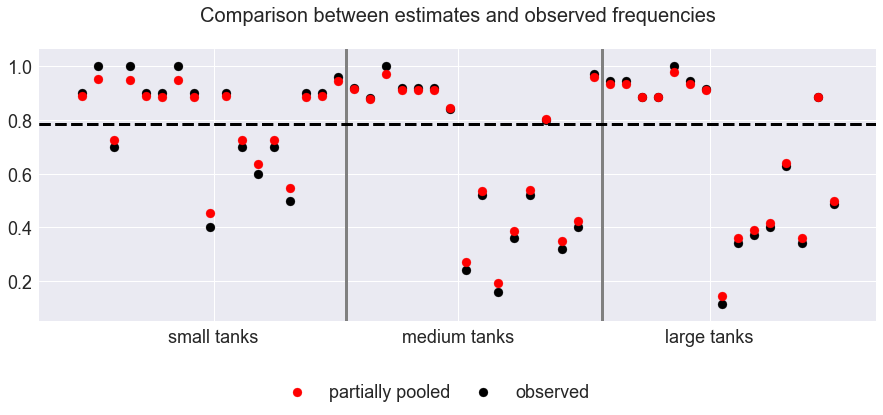

In [116]:
plot_regularize()

## Use the hierarchical model to simulate new tanks!

In [112]:
ma = tad_ppooled_trace[n_warm:]['mu_a']
sa = tad_ppooled_trace[n_warm:]['sigma_a']

index = np.random.randint(0, ma.shape[0], 100)
h = np.arange(-4,4,.1)

samples = np.empty((0,0))

for m, s in zip(ma[index], sa[index]):
    samples = np.append(samples, np.random.normal(m,s,100))

In [113]:
def plot_newtanks():
    fig = plt.figure(figsize=(15, 5));
    ax1 = fig.add_subplot(121)
    for m, s in zip(ma[index], sa[index]):
        plt.plot(h, stats.norm.pdf(h,m,s), c = 'k', alpha = 0.1)
    plt.title('Randomly generated tanks from the population', fontsize = 18)
    ax1.set_xlabel('log-odds survive'); 

    ax2 = fig.add_subplot(122)
    plt.hist(np.exp(samples) / (1+ np.exp(samples)), bins= 50);
    plt.title('Survival in an aquarium', fontsize = 18)
    ax2.set_xlabel('probability of survive');

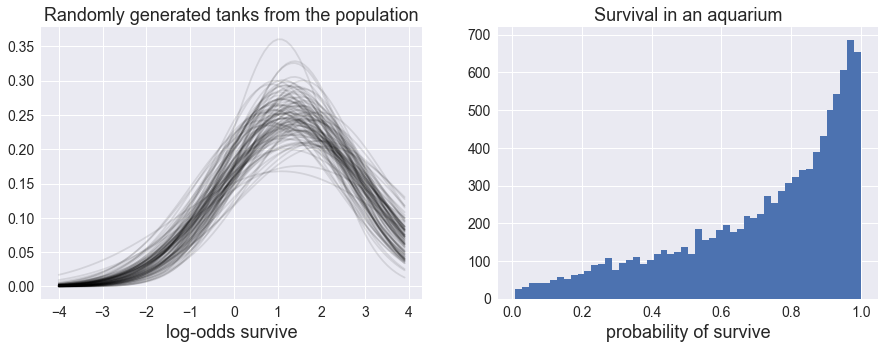

In [114]:
plot_newtanks()

## Another insight: Poisson regression and the count of tools

In [56]:
d = {'culture' :['Malekula','Tikopia','Santa Cruz','Yap','Lau Fiji','Trobriand','Chuuk','Manus','Tonga','Hawaii'],
     'population': [1100,   1500,   3600,   4791,   7400,   8000,   9200,  13000,  17500 ,275000],
     'tools':[13, 22, 24, 43, 33, 19, 40, 28, 55, 71], 
     'contact':['low','low','low','high','high','high','high','low','high','low']
    }
df = pd.DataFrame(d)    

In [57]:
df

,contact,culture,population,tools
0,low,Malekula,1100,13
1,low,Tikopia,1500,22
2,low,Santa Cruz,3600,24
3,high,Yap,4791,43
4,high,Lau Fiji,7400,33
5,high,Trobriand,8000,19
6,high,Chuuk,9200,40
7,low,Manus,13000,28
8,high,Tonga,17500,55
9,low,Hawaii,275000,71


In [58]:
log_pop = np.log(df.population)
contact = df.contact.replace(dict(zip(df.contact.unique(), range(2))))

## Full model (linear with interactions)

In [59]:
with Model() as island_m1:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    beta = Normal('beta', 0, sd = 1e0, shape = 3)
    # Linear Model
    theta = alpha + beta[0] * log_pop + beta[1] * contact + beta[2] * contact * log_pop
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m1_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 1)    

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 5.7581e+16:   1%|▏         | 655/50000 [00:00<00:07, 6543.53it/s]
Convergence archived at 900
Interrupted at 900 [1%]: Average Loss = 1.6915e+08
100%|██████████| 4000/4000 [00:26<00:00, 150.54it/s]


## Full linear model (no interactions)

In [60]:
with Model() as island_m2:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    beta = Normal('beta', 0, sd = 1e0, shape = 2)
    # Linear Model
    theta = alpha + beta[0] * log_pop + beta[1] * contact 
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m2_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 1) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 7.7398e+06:   3%|▎         | 1343/50000 [00:00<00:07, 6799.16it/s]
Convergence archived at 2000
Interrupted at 2,000 [4%]: Average Loss = 7.6638e+06
100%|██████████| 4000/4000 [00:14<00:00, 271.45it/s]


## One predictor

In [61]:
with Model() as island_m3:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    beta = Normal('beta', 0, sd = 1e0, shape = 1)
    # Linear Model
    theta = alpha + beta[0] * log_pop 
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m3_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 1) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
  0%|          | 0/50000 [00:00<?, ?it/s]
Convergence archived at 400
Interrupted at 400 [0%]: Average Loss = 4.4111e+08
100%|██████████| 4000/4000 [00:08<00:00, 448.25it/s]


## The other predictor

In [62]:
with Model() as island_m4:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    beta = Normal('beta', 0, sd = 1e0, shape = 1)
    # Linear Model
    theta = alpha + beta[0] * contact
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m4_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 78.338:  35%|███▌      | 17578/50000 [00:02<00:04, 7573.48it/s]
Convergence archived at 18100
Interrupted at 18,100 [36%]: Average Loss = 275.95
100%|██████████| 4000/4000 [00:08<00:00, 492.20it/s]


## No predictors

In [63]:
with Model() as island_m5:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    # Linear Model
    theta = alpha
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m5_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 76.04:  34%|███▍      | 17000/50000 [00:02<00:04, 7628.55it/s] 
Convergence archived at 17000
Interrupted at 17,000 [34%]: Average Loss = 328.7
100%|██████████| 4000/4000 [00:04<00:00, 882.51it/s]


In [64]:
traces = [island_m1_trace, island_m2_trace, island_m3_trace, island_m4_trace, island_m5_trace]
models = [island_m1, island_m2, island_m3, island_m4, island_m5]

## Model averaging

In [65]:
dfwaic = pm.stats.compare(traces, models)
dfwaic

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,79.2299,4.29325,0,0.534795,11.0291,0,0
0,79.6988,4.64466,0.468912,0.423024,11.0223,1.17159,0
2,84.3097,3.69025,5.07982,0.0421811,8.95537,7.86293,0
4,141.993,8.73487,62.7628,1.25725e-14,31.6687,32.5132,0
3,149.859,16.6703,70.6289,2.46216e-16,44.9049,44.3913,0


In [66]:
weights = dfwaic.weight[range(2)]/dfwaic.weight[range(2)].sum()
weights

0    0.441653
1    0.558347
Name: weight, dtype: object

In [67]:
index = np.random.randint(0,2000,100)
beta_m2 = island_m2_trace[n_warm:]['beta']
alpha_m2 = island_m2_trace[n_warm:]['alpha']

h = np.arange(7, 14, .1)

hicontact = np.exp((alpha_m2 + beta_m2[:,1])[index,np.newaxis] + np.multiply(beta_m2[:,0][index,np.newaxis], h))
locontact = np.exp((alpha_m2)[index,np.newaxis] + np.multiply(beta_m2[:,0][index,np.newaxis], h))

In [68]:
index = np.random.randint(0,2000,100)
beta_m1 = island_m1_trace[n_warm:]['beta']
alpha_m1 = island_m1_trace[n_warm:]['alpha']

hicontact1 = np.exp((alpha_m1 + beta_m1[:,1])[index,np.newaxis] + np.multiply(beta_m1[:,np.arange(0,3,2)].sum(axis=1)[index,np.newaxis], h))
locontact1 = np.exp((alpha_m1)[index,np.newaxis] + np.multiply(beta_m1[:,0][index,np.newaxis], h))

In [81]:
def plot_modelavg():
    fig = plt.figure(figsize=(15, 5));
    plt.subplot(131)
    plt.title('Typical linear model (%s)\n'%(round(weights[1],2)), fontsize = 18)
    plt.plot(h, np.percentile(hicontact, [50], axis = 0).T, 'r', label = 'high contact');
    plt.plot(h, np.percentile(locontact, [50], axis = 0).T, 'b', label = 'low contact');
    plt.legend(fontsize = 18, loc=0);
    plt.fill_between(h, np.percentile(hicontact,[5],axis=0)[0], np.percentile(hicontact,[95],axis=0)[0],facecolor='r',alpha=.2);
    plt.fill_between(h, np.percentile(locontact,[5],axis=0)[0], np.percentile(locontact,[95],axis=0)[0],facecolor='b',alpha=.2);
    plt.scatter(log_pop[contact==1], df.tools[contact==1],c='r');
    plt.scatter(log_pop[contact==0], df.tools[contact==0],c='b');

    plt.ylim((10,100))

    plt.subplot(132)
    plt.title('Full linear model (%s)\n'%(round(weights[0],2)), fontsize = 18)
    plt.plot(h, np.percentile(hicontact1, [50], axis = 0).T, 'r', label = 'high contact');
    plt.plot(h, np.percentile(locontact1, [50], axis = 0).T, 'b', label = 'low contact');
    plt.legend(fontsize = 18, loc=0);
    plt.fill_between(h, np.percentile(hicontact1,[5],axis=0)[0], np.percentile(hicontact1,[95],axis=0)[0],facecolor='r',alpha=.2);
    plt.fill_between(h, np.percentile(locontact1,[5],axis=0)[0], np.percentile(locontact1,[95],axis=0)[0],facecolor='b',alpha=.2);
    plt.scatter(log_pop[contact==1], df.tools[contact==1],c='r');
    plt.scatter(log_pop[contact==0], df.tools[contact==0],c='b');

    plt.ylim((10,100))

    plt.subplot(133)
    plt.title('Model average\n', fontsize = 18)
    
    plt.plot(h, np.percentile(.65*hicontact+.35*hicontact1, [50], axis = 0).T, 'r', label = 'high contact');
    plt.plot(h, np.percentile(.65*locontact+.35*locontact1, [50], axis = 0).T, 'b', label = 'low contact');
    plt.legend(fontsize = 18, loc=0);
    
    plt.plot(h, np.percentile(hicontact1, [50], axis = 0).T, 'r--');
    plt.plot(h, np.percentile(hicontact, [50], axis = 0).T, 'r:');
    plt.plot(h, np.percentile(locontact1, [50], axis = 0).T, 'b--');
    plt.plot(h, np.percentile(locontact, [50], axis = 0).T, 'b:');
    
    plt.fill_between(h, np.percentile(hicontact,[5],axis=0)[0], np.percentile(hicontact,[95],axis=0)[0],facecolor='r',alpha=.1);
    plt.fill_between(h, np.percentile(hicontact1,[5],axis=0)[0], np.percentile(hicontact1,[95],axis=0)[0],facecolor='r',alpha=.1);
    plt.fill_between(h, np.percentile(weights[1]*hicontact+weights[0]*hicontact1,[5],axis=0)[0], np.percentile(weights[1]*hicontact+weights[0]*hicontact1,[95],axis=0)[0],facecolor='r',alpha=.3);

    plt.fill_between(h, np.percentile(locontact,[5],axis=0)[0], np.percentile(locontact,[95],axis=0)[0],facecolor='b',alpha=.1);
    plt.fill_between(h, np.percentile(locontact1,[5],axis=0)[0], np.percentile(locontact1,[95],axis=0)[0],facecolor='b',alpha=.1);
    plt.fill_between(h, np.percentile(weights[1]*locontact+weights[0]*locontact1,[5],axis=0)[0], np.percentile(weights[1]*locontact+weights[0]*locontact1,[95],axis=0)[0],facecolor='b',alpha=.3);

   
    plt.scatter(log_pop[contact==1], df.tools[contact==1],c='r');
    plt.scatter(log_pop[contact==0], df.tools[contact==0],c='b');

    plt.ylim((10,100));

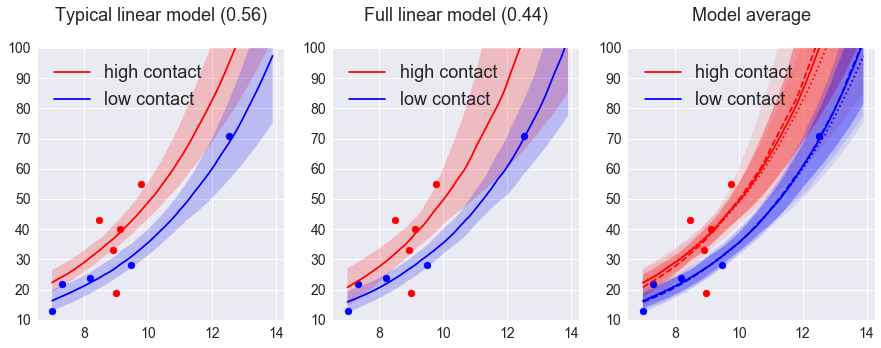

In [82]:
plot_modelavg()

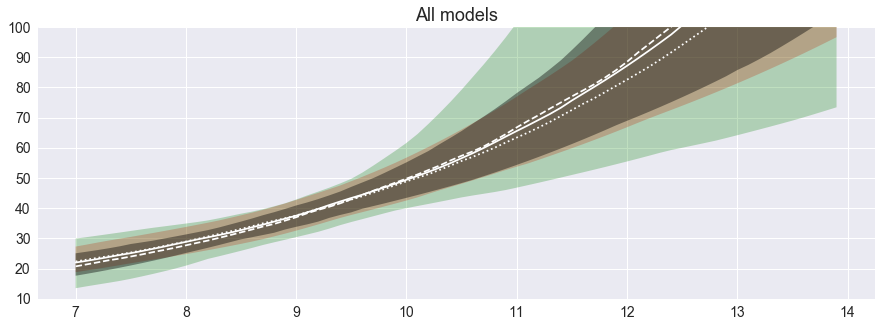

In [99]:
fig = plt.figure(figsize=(15, 5));
plt.plot(h, np.percentile(hicontact1, [50], axis = 0).T, 'w--', label = 'high contact');
plt.plot(h, np.percentile(hicontact, [50], axis = 0).T, 'w:', label = 'high contact');
plt.plot(h, np.percentile(weights[1]*hicontact + weights[0]*hicontact1, [50], axis = 0).T, 'w', label = 'high contact');

plt.title('All models', fontsize = 18)

plt.fill_between(h, np.percentile(hicontact,[2.5],axis=0)[0], np.percentile(hicontact,[97.5],axis=0)[0],facecolor='r',alpha=.25);
plt.fill_between(h, np.percentile(hicontact1,[2.5],axis=0)[0], np.percentile(hicontact1,[97.5],axis=0)[0],facecolor='g',alpha=.25);
plt.fill_between(h, np.percentile(weights[1]*hicontact+weights[0]*hicontact1,[5],axis=0)[0], np.percentile(weights[1]*hicontact+weights[0]*hicontact1,[95],axis=0)[0],facecolor='black',alpha=.4);

plt.ylim((10,100));

In [100]:
society = np.arange(10)

## Hierarchical model

In [101]:
with Model() as island_multi:
    # Priors
    sigma_soc = HalfCauchy('sigma_soc', 1)
    alpha = Normal('alpha', 0, sd = 1e1)
    alpha_soc = Normal('alpha_soc', 0, sd = sigma_soc, shape = 10)
    beta = Normal('beta', 0, sd = 1e0)
    # Linear Model
    theta = alpha + alpha_soc[society] + beta * log_pop 
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_multi_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 3) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 54.215:  57%|█████▋    | 28567/50000 [00:05<00:03, 5409.71it/s]   
Convergence archived at 29000
Interrupted at 29,000 [58%]: Average Loss = 8.343e+06
 89%|████████▉ | 3567/4000 [01:13<00:09, 43.43it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:457: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.643450199188, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 2 contains 117 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 3997/4000 [01:22<00:00, 47.91it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/sit

In [102]:
pm.stats.waic(island_multi_trace, island_multi)

WAIC_r(WAIC=70.231552298349598, WAIC_se=2.530979765913167, p_WAIC=5.0718020966378248)

In [103]:
traces = [island_m1_trace, island_m2_trace, island_m3_trace, island_m4_trace, island_m5_trace, island_multi_trace]
models = [island_m1, island_m2, island_m3, island_m4, island_m5, island_multi]

## Model comparison

In [104]:
pm.stats.compare(traces, models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
5,70.2316,5.0718,0,0.979634,2.53098,0,0
1,79.2299,4.29325,8.99834,0.0108918,11.0291,9.87767,0
0,79.6988,4.64466,9.46725,0.00861543,11.0223,9.76603,0
2,84.3097,3.69025,14.0782,0.000859073,8.95537,6.906,0
4,141.993,8.73487,71.7611,2.56056e-16,31.6687,31.1129,0
3,149.859,16.6703,79.6272,5.0145e-18,44.9049,44.174,0


In [105]:
index_soc = np.random.randint(0,6000,1000)
index = np.random.randint(0,6000,1000)

alpha_m = island_multi_trace[n_warm:]['alpha']
beta_m = island_multi_trace[n_warm:]['beta']
sigma_soc_m = island_multi_trace[n_warm:]['sigma_soc']

In [106]:
rsoc = np.random.normal(0,sigma_soc_m[index_soc], size = (2000,1000))

In [107]:
res = rsoc[:,:,np.newaxis] + alpha_m[index,np.newaxis] + np.multiply(beta_m[index,np.newaxis], h)

p50 = np.percentile(res, 50, axis = (0,1))
plo = np.percentile(res, [2.5, 5, 10], axis = (0,1))
phi = np.percentile(res, [97.5, 95, 90], axis = (0,1))

## Model output: *overdispersed Poisson model*

In [108]:
def plot_overdisp():
    fig = plt.figure(figsize=(15, 5));
    plt.plot(h, np.exp(p50), 'k')
    plt.title('Hierarchical model: Simulated tanks\n', fontsize = 18)
    plt.fill_between(h, np.exp(plo)[0], np.exp(phi)[0], facecolor = 'gray', alpha = .25)
    plt.fill_between(h, np.exp(plo)[1], np.exp(phi)[1], facecolor = 'gray', alpha = .25)
    plt.fill_between(h, np.exp(plo)[2], np.exp(phi)[2], facecolor = 'gray', alpha = .25)
    plt.scatter(log_pop, df.tools, c = 'r');
    plt.ylim((10,100));

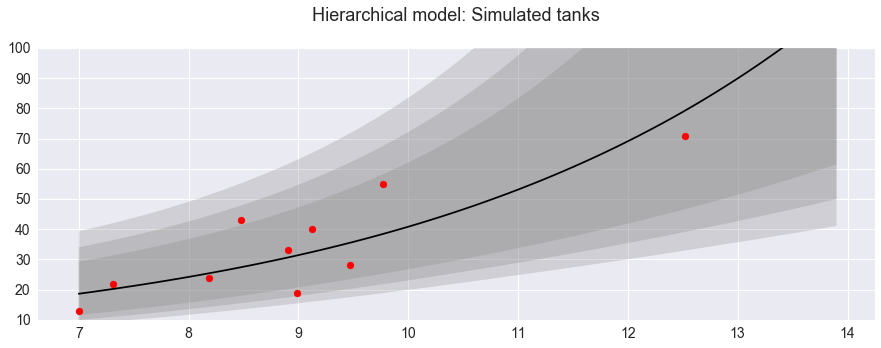

In [109]:
plot_overdisp()